In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd

import duckdb
def query(s):
    return duckdb.sql(s).df()

# books_metadata = kagglehub.dataset_load(
#   KaggleDatasetAdapter.PANDAS,
#   "hadifariborzi/amazon-books-dataset-20k-books-727k-reviews",
#   "amazon_books_metadata_sample_20k.csv",
# )

# books_reviews = kagglehub.dataset_load(
#   KaggleDatasetAdapter.PANDAS,
#   "hadifariborzi/amazon-books-dataset-20k-books-727k-reviews",
#   "amazon_books_reviews_sample_20k.csv",
# )



/home/toby/Documents/Data Visualization/Codes/.venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
pd.set_option('display.max_columns', None)

In [32]:
# (Optional) Save the file locally 
import os

outdir = './dataset'
if not os.path.exists(outdir):
    os.mkdir(outdir)

books_metadata.to_csv('./dataset/metadata.csv',)
books_reviews.to_csv('./dataset/reviews.csv')

In [2]:
books_metadata=pd.read_csv('./dataset/metadata.csv')
books_reviews=pd.read_csv('./dataset/reviews.csv')

In [3]:
df1 = books_metadata
df2 = books_reviews

# Explore Books Data
- Data shape 20.000 books, and 28 columns
- Every row that has missing *page_count* also has missing *format*.
- *bought_together* all values is missing, can be dropped
- *category_level_1_main* unique values is just Books or NaN, can be dropped
- *image* and *video* aren't going to be used, can be dropped
- Out of 20k books, there are 423 duplicated titles. Due to different *format*. Duplicates has different *isbn_10*, *isbn_13*.
- 161 missing publishing date

## Exploratory (messy)

In [17]:
books_metadata.head(3)

,title,subtitle,author_name,author_about,publisher,publisher_date,format,page_count,language,isbn_10,isbn_13,main_category,category_level_1_main,category_level_2_sub,category_level_3_detail,average_rating,rating_number,price,price_numeric,description,features_text,dimensions,item_weight,images,videos,store,parent_asin,bought_together
0,Government Bullies: How Everyday Americans are...,"Paperback – August 6, 2013",Rand Paul,"Discover more of the author’s books, see simil...",Center Street,"41260th edition (August 6, 2013",Paperback,320.0,English,1455522775,978-1455522774,Books,Books,Politics & Social Sciences,Politics & Government,4.6,274,12.99,12.99,"['Review', 'Praise for The Tea Party Goes to W...",Government regulations are out of control. The...,5.25 x 0.81 x 8 inches,9.2 ounces,[{'large': 'https://m.media-amazon.com/images/...,[],"Rand Paul (Author), Ron Paul (Foreword)",1455522775,NaN
1,Gordon Pope Thrillers: Books 1-3,"Paperback – December 17, 2020",B. B. Griffith,"B. B. Griffith was born and raised in Denver, ...",Griffith Publishing LLC,"December 17, 2020",Paperback,694.0,English,1735305855,978-1735305851,Books,Books,Literature & Fiction,Genre Fiction,4.6,626,24.69,24.69,"['Review', 'Selected Reviews from the Gordon P...",Gordon Pope has a special talent. | He's the o...,6 x 1.74 x 9 inches,2.21 pounds,[{'large': 'https://m.media-amazon.com/images/...,[],B. B. Griffith (Author),1735305855,NaN
2,Chart Sense: Common Sense Charts to Teach 3-8 ...,"Paperback – Illustrated, February 2, 2014",Rozlyn Linder,Follow Roz on Twitter (@rozlinder) and connect...,"Literacy Initiative, The","Illustrated edition (February 2, 2014",Paperback,182.0,English,0988950510,978-0988950511,Books,Books,Education & Teaching,Schools & Teaching,4.7,272,22.88,22.88,"['Review', ""This is the first book I have ever...",Chart Sense is the ultimate resource for eleme...,7.5 x 0.41 x 9.25 inches,12 ounces,[],[],Rozlyn Linder (Author),0988950510,NaN


In [28]:
len(df1)

20000

In [29]:
for i in df1.columns:
    print(i)
print(df1.shape)

title
subtitle
author_name
author_about
publisher
publisher_date
format
page_count
language
isbn_10
isbn_13
main_category
category_level_1_main
category_level_2_sub
category_level_3_detail
average_rating
rating_number
price
price_numeric
description
features_text
dimensions
item_weight
images
videos
store
parent_asin
bought_together
(20000, 28)


In [15]:
df1.describe()

,page_count,average_rating,rating_number,price,price_numeric,bought_together
count,15544.000000,20000.000000,20000.000000,20000.000000,20000.000000,0.0
mean,330.958312,4.466935,2488.503550,18.782429,18.782429,NaN
std,224.197156,0.255960,7772.758403,85.824619,85.824619,NaN
min,0.000000,2.500000,200.000000,5.010000,5.010000,NaN
25%,224.000000,4.300000,333.000000,9.990000,9.990000,NaN
50%,312.000000,4.500000,651.000000,13.990000,13.990000,NaN
75%,386.000000,4.700000,1734.000000,18.950000,18.950000,NaN
max,9998.000000,5.000000,278592.000000,11568.310000,11568.310000,NaN


In [27]:
missing = df1.isna().sum().sort_values(ascending=False)
missing

bought_together            20000
format                      4456
page_count                  4456
isbn_10                     1858
isbn_13                     1751
dimensions                  1561
item_weight                 1451
subtitle                    1400
category_level_3_detail      302
publisher_date               161
category_level_1_main        118
category_level_2_sub         118
publisher                     55
features_text                 33
store                         30
language                      25
main_category                  0
title                          0
author_name                    0
author_about                   0
description                    0
price_numeric                  0
price                          0
rating_number                  0
average_rating                 0
images                         0
videos                         0
parent_asin                    0
dtype: int64

In [35]:
df1[df1['format'].isna() | df1['page_count'].isna()]

,title,subtitle,author_name,author_about,publisher,publisher_date,format,page_count,language,isbn_10,isbn_13,main_category,category_level_1_main,category_level_2_sub,category_level_3_detail,average_rating,rating_number,price,price_numeric,description,features_text,dimensions,item_weight,images,videos,store,parent_asin,bought_together
8,"Daylight (An Atlee Pine Thriller, 3)","Mass Market Paperback – February 22, 2022",David Baldacci,David Baldacci has been writing since childhoo...,Grand Central Publishing,"February 22, 2022",NaN,NaN,English,1538761661,978-1538761663,Books,Books,Literature & Fiction,Action & Adventure,4.5,37939,7.48,7.48,"['Review', '""Baldacci is at his absolute best ...",In this gripping mystery from #1 | New York Ti...,4.25 x 1.65 x 7.45 inches,9.6 ounces,[],[],David Baldacci (Author),1538761661,NaN
10,Do Your Happy Dance!: Celebrate Wonderful You ...,"Board book – March 29, 2016",Charles M. Schulz,"Charles M. Schulz was born November 25, 1922 i...",Simon Spotlight,"Brdbk edition (March 29, 2016",NaN,NaN,English,1481458922,978-1481458924,Books,Books,Children's Books,Growing Up & Facts of Life,4.8,302,7.99,7.99,"['About the Author', 'Charles M. Schulz is a l...","Dream big, try your best, then do your happy d...",5.75 x 0.6 x 6.9 inches,12.8 ounces,[{'large': 'https://m.media-amazon.com/images/...,[],"Elizabeth Dennis Barton (Adapter), Charles M....",1481458922,NaN
16,The Queen's Head: The dramatic Elizabethan who...,Kindle Edition,Edward Marston,"Discover more of the author’s books, see simil...",Allison & Busby,"March 26, 2012",NaN,NaN,English,NaN,NaN,Buy a Kindle,Books,"Mystery, Thriller & Suspense",Thrillers & Suspense,4.2,395,9.99,9.99,"['About the Author', ""Edward Marston has writt...","His name was Will Fowler, an actor in the este...",NaN,NaN,[{'large': 'https://m.media-amazon.com/images/...,[],Edward Marston (Author) Format: Kindle Edition,B0079JY2M2,NaN
17,The House of Wolves: Bolder Than Yellowstone o...,Kindle Edition,Mike Lupica,Mike Lupica is one of the most prominent sport...,"Little, Brown and Company","January 9, 2023",NaN,NaN,English,NaN,NaN,Buy a Kindle,Books,"Mystery, Thriller & Suspense",Thrillers & Suspense,4.5,12653,14.99,14.99,"['About the Author', 'James Patterson', 'is th...",Instant | New York Times | Bestseller! | James...,NaN,NaN,[{'large': 'https://m.media-amazon.com/images/...,[],"James Patterson (Author), Mike Lupica (Author...",B0B5YFY8JP,NaN
19,Serial (A Frank Quinn Novel),"Mass Market Paperback – August 1, 2011",John Lutz,"John Lutz's work includes political suspense, ...",Pinnacle,"1st edition (August 1, 2011",NaN,NaN,English,9780786020270,978-0786020270,Books,Books,"Mystery, Thriller & Suspense",Thrillers & Suspense,4.3,508,7.34,7.34,"['About the Author', 'A multiple Edgar and Sha...",The Killer Becomes The Hunted | She was gagged...,4.27 x 1.36 x 6.76 inches,8.3 ounces,[{'large': 'https://m.media-amazon.com/images/...,[],John Lutz (Author),078602027X,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19990,"The Supernaturals (The Supernaturals, 1)","Mass Market Paperback – October 30, 2018",David L. Golemon,"David was born and raised in Chino, California...",St. Martin's Paperbacks,"Reissue edition (October 30, 2018",NaN,NaN,English,1250191017,978-1250191014,Books,Books,Literature & Fiction,Genre Fiction,4.4,389,8.99,8.99,"['Review', '""[A]n explosive combination that f...",Named One of Riffle's Ten Best Haunted House B...,4.25 x 1.33 x 6.79 inches,8 ounces,[{'large': 'https://m.media-amazon.com/images/...,[],David L. Golemon (Author),1250191017,NaN
19991,"The Scarecrow (Jack McEvoy, 2)","Mass Market Paperback – September 25, 2018",Michael Connelly,Michael Connelly is the bestselling author of ...,Grand Central Publishing,"Reissue edition (September 25, 2018",NaN,NaN,English,1478948280,978-1478948285,Books,Books,"Mystery, Thriller & Suspense",Thrillers & Suspense,4.5,15649,9.99,9.99,"['Review', '""Conne

In [50]:
len(books_metadata['title'].unique())

18140

In [44]:
#Duplicated titles
books_metadata['title'][books_metadata['title'].duplicated()].unique()

array(['Coromandel: A Personal History of South India', 'Broken',
       'Sins of the Fathers', 'Never Too Late',
       'The Ramayana: A Modern Retelling of the Great Indian Epic',
       'The Tipping Point: How Little Things Can Make a Big Difference',
       'El Monstruo de Colores (Spanish Edition)',
       'The Better Angels of Our Nature: Why Violence Has Declined',
       'The Broken Shore: A Novel', 'The Jungle Book',
       'Wild Ducks Flying Backward',
       'The Dutch House: A Read with Jenna Pick',
       'The Heiresses: A Novel',
       "Li'l Rabbit's Kwanzaa: A Kwanzaa Holiday Book for Kids",
       'Rescue of the Bounty: Disaster and Survival in Superstorm Sandy',
       'How to be both: A novel',
       "21 Pounds in 21 Days: The Martha's Vineyard Diet Detox",
       'Happy People Are Annoying', 'Substance: Inside New Order',
       'The Wolf: A Novel', 'A Week in Winter', 'False Witness: A Novel',
       'The Lazarus Project', 'Against the Tide (The Brodies Of Alaska)

In [47]:
len(books_metadata['title'][books_metadata['title'].duplicated()].unique())

423

In [45]:
df1[df1['title']=='Coromandel: A Personal History of South India']

,title,subtitle,author_name,author_about,publisher,publisher_date,format,page_count,language,isbn_10,isbn_13,main_category,category_level_1_main,category_level_2_sub,category_level_3_detail,average_rating,rating_number,price,price_numeric,description,features_text,dimensions,item_weight,images,videos,store,parent_asin,bought_together
79,Coromandel: A Personal History of South India,"Paperback – May 14, 2019",Charles Allen,"Discover more of the author’s books, see simil...",Abacus,"Reprint edition (May 14, 2019",Paperback,432.0,English,0349140111,978-0349140117,Books,Books,History,Asia,4.3,253,17.99,17.99,"['Review', 'Coromandel', 'is lively and its st...",COROMANDEL | . A name which has been long appl...,5.25 x 1.25 x 8 inches,12 ounces,[],[],Charles Allen (Author),0349140111,NaN
554,Coromandel: A Personal History of South India,"Hardcover – September 25, 2018",Charles Allen,"Discover more of the author’s books, see simil...","Little, Brown UK","Illustrated edition (September 25, 2018",Hardcover,432.0,English,9781408705391,978-1408705391,Books,Books,History,Asia,4.3,251,22.64,22.64,"['Review', 'Coromandel', 'is lively and its st...",COROMANDEL | . A name which has been long appl...,6.5 x 1.25 x 9.5 inches,1.55 pounds,[{'large': 'https://m.media-amazon.com/images/...,[],Charles Allen (Author),1408705397,NaN


In [46]:
df1[df1['title']=='Long Spoon Lane: A Charlotte and Thomas Pitt Novel']

,title,subtitle,author_name,author_about,publisher,publisher_date,format,page_count,language,isbn_10,isbn_13,main_category,category_level_1_main,category_level_2_sub,category_level_3_detail,average_rating,rating_number,price,price_numeric,description,features_text,dimensions,item_weight,images,videos,store,parent_asin,bought_together
2916,Long Spoon Lane: A Charlotte and Thomas Pitt N...,"Paperback – March 28, 2006",Anne Perry,Anne Perry is the bestselling author of two ac...,Ballantine Books,"March 28, 2006",Paperback,352.0,English,0345469283,978-0345469281,Books,Books,Literature & Fiction,Genre Fiction,4.6,750,5.98,5.98,"['Review', 'Praise for Anne Perry’s Charlotte ...",Anne Perry’s bestselling Victorian novels offe...,4.25 x 1 x 7 inches,6.1 ounces,[{'large': 'https://m.media-amazon.com/images/...,[],Anne Perry (Author),0345469283,NaN
5638,Long Spoon Lane: A Charlotte and Thomas Pitt N...,"Paperback – October 4, 2011",Anne Perry,Anne Perry is the bestselling author of two ac...,Ballantine Books,"Reprint edition (October 4, 2011",Paperback,336.0,English,0345523725,978-0345523723,Books,Books,Literature & Fiction,History & Criticism,4.6,758,17.00,17.00,"['Review', '“Elegant . . . The clear parallels...",“[Anne] Perry has once again delivered the tas...,5.13 x 0.7 x 7.92 inches,10.4 ounces,[{'large': 'https://m.media-amazon.com/images/...,[],Anne Perry (Author),0345523725,NaN


# Data Cleaning
- fix publisher date -> there now more missing dates(264)

In [6]:
import re
import pandas as pd

def extract_full_date(text):
    if not isinstance(text, str):
        return None

    # 1️⃣ Find date inside parentheses if present
    match = re.search(
        r'\b(January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{1,2},\s+\d{4}\b',
        text
    )
    if match:
        return match.group(0)

    # 2️⃣ If not in parentheses, check the plain text
    match = re.search(
        r'\b(January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{1,2},\s+\d{4}\b',
        text
    )
    if match:
        return match.group(0)

    return None

books_metadata['clean_date_str'] = books_metadata['publisher_date'].apply(extract_full_date)
books_metadata['publish_date_fix'] = pd.to_datetime(
    books_metadata['clean_date_str'],
    errors='coerce'
)



In [89]:
books_metadata.head()

,Unnamed: 0,title,subtitle,author_name,author_about,publisher,publisher_date,format,page_count,language,isbn_10,isbn_13,main_category,category_level_1_main,category_level_2_sub,category_level_3_detail,average_rating,rating_number,price,price_numeric,description,features_text,dimensions,item_weight,images,videos,store,parent_asin,bought_together,clean_date_str,publish_date_fix
0,0,Government Bullies: How Everyday Americans are...,"Paperback – August 6, 2013",Rand Paul,"Discover more of the author’s books, see simil...",Center Street,"41260th edition (August 6, 2013",Paperback,320.0,English,1455522775,978-1455522774,Books,Books,Politics & Social Sciences,Politics & Government,4.6,274,12.99,12.99,"['Review', 'Praise for The Tea Party Goes to W...",Government regulations are out of control. The...,5.25 x 0.81 x 8 inches,9.2 ounces,[{'large': 'https://m.media-amazon.com/images/...,[],"Rand Paul (Author), Ron Paul (Foreword)",1455522775,NaN,"August 6, 2013",2013-08-06
1,1,Gordon Pope Thrillers: Books 1-3,"Paperback – December 17, 2020",B. B. Griffith,"B. B. Griffith was born and raised in Denver, ...",Griffith Publishing LLC,"December 17, 2020",Paperback,694.0,English,1735305855,978-1735305851,Books,Books,Literature & Fiction,Genre Fiction,4.6,626,24.69,24.69,"['Review', 'Selected Reviews from the Gordon P...",Gordon Pope has a special talent. | He's the o...,6 x 1.74 x 9 inches,2.21 pounds,[{'large': 'https://m.media-amazon.com/images/...,[],B. B. Griffith (Author),1735305855,NaN,"December 17, 2020",2020-12-17
2,2,Chart Sense: Common Sense Charts to Teach 3-8 ...,"Paperback – Illustrated, February 2, 2014",Rozlyn Linder,Follow Roz on Twitter (@rozlinder) and connect...,"Literacy Initiative, The","Illustrated edition (February 2, 2014",Paperback,182.0,English,0988950510,978-0988950511,Books,Books,Education & Teaching,Schools & Teaching,4.7,272,22.88,22.88,"['Review', ""This is the first book I have ever...",Chart Sense is the ultimate resource for eleme...,7.5 x 0.41 x 9.25 inches,12 ounces,[],[],Rozlyn Linder (Author),0988950510,NaN,"February 2, 2014",2014-02-02
3,3,Where the Sky Begins: A Novel,"Paperback – August 2, 2022",Rhys Bowen,Rhys Bowen is the New York Times bestselling a...,Lake Union Publishing,"August 2, 2022",Paperback,399.0,English,1542028841,978-1542028844,Books,Books,Literature & Fiction,Genre Fiction,4.5,27244,6.15,6.15,"['Review', '“Bowen is a master at winning read...",A woman’s future is determined by fate and cho...,5.5 x 1 x 8.25 inches,14.1 ounces,[],[],Rhys Bowen (Author),1542028841,NaN,"August 2, 2022",2022-08-02
4,4,The Mystery of Garabandal: Fantasy or Fraud? G...,NaN,LR Walker,"Discover more of the author’s books, see simil...",Newtonia Publishing LLC,"First Paperback Edition (July 31, 2015",Paperback,299.0,English,0692297677,978-0692297674,Books,Books,Christian Books & Bibles,Theology,4.5,287,12.99,12.99,"['About the Author', ""LR Walker studied journa...",This 2021 update includes new interviews with ...,6 x 0.68 x 9 inches,14.3 ounces,[{'large': 'https://m.media-amazon.com/images/...,[],"LR Walker (Author), Frank Lafleur (Introduction)",0692297677,NaN,"July 31, 2015",2015-07-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19995,The Prayer of the Lord,"Hardcover – May 26, 2009",R. C. Sproul,Dr. R.C. Sproul (1939–2017) was founder of Lig...,Reformation Trust Publishing,"May 26, 2009",Hardcover,130.0,English,1567691188,978-1567691184,Books,Books,Christian Books & Bibles,Worship & Devotion,4.7,512,18.67,18.67,"['Review', ""R.C. Sproul has an amazing gift fo...",What is the Lord’s Prayer? In | The Prayer of ...,5.31 x 0.63 x 7.75 inches,9.6 ounces,[{'large': 'https://m.media-amazon.com/images/...,[],R.C. Sproul (Author),1567691188,NaN,"May 26, 2009",2009-05-26
19996,19996,A Christmas Carol,"Hardcover – September 3, 2012",Robert Ingpen,"Robert Ingpen was born in 1936 in Geelong, Aus...",Chartwell Books,"Reprint edition 

In [8]:
books_metadata[['publisher_date', 'publish_date_fix']].sample(20, random_state=2)

,publisher_date,publish_date_fix
836,"September 10, 2013",2013-09-10
1849,"1st edition (September 2, 2008",2008-09-02
16673,"January 1, 2015",2015-01-01
527,"Illustrated edition (July 7, 2020",2020-07-07
19846,"May 18, 2021",2021-05-18
1497,"September 15, 2009",2009-09-15
16622,"Illustrated edition (November 6, 2018",2018-11-06
5043,"September 17, 2014",2014-09-17
16981,"Reprint edition (April 21, 2009",2009-04-21
19634,"Original edition (November 8, 2016",2016-11-08


In [96]:
books_metadata.isna().sum()

Unnamed: 0                     0
title                          0
subtitle                    1400
author_name                    0
author_about                   0
publisher                     55
publisher_date               161
format                      4456
page_count                  4456
language                      25
isbn_10                     1858
isbn_13                     1751
main_category                  0
category_level_1_main        118
category_level_2_sub         118
category_level_3_detail      302
average_rating                 0
rating_number                  0
price                          0
price_numeric                  0
description                    0
features_text                 33
dimensions                  1561
item_weight                 1451
images                         0
videos                         0
store                         30
parent_asin                    0
bought_together            20000
clean_date_str               264
publish_da

# Visualization ideas 
- Page count vs Popularity
- Books released

In [80]:
df1.tail()

,title,subtitle,author_name,author_about,publisher,publisher_date,format,page_count,language,isbn_10,isbn_13,main_category,category_level_1_main,category_level_2_sub,category_level_3_detail,average_rating,rating_number,price,price_numeric,description,features_text,dimensions,item_weight,images,videos,store,parent_asin,bought_together
19995,The Prayer of the Lord,"Hardcover – May 26, 2009",R. C. Sproul,Dr. R.C. Sproul (1939–2017) was founder of Lig...,Reformation Trust Publishing,"May 26, 2009",Hardcover,130.0,English,1567691188,978-1567691184,Books,Books,Christian Books & Bibles,Worship & Devotion,4.7,512,18.67,18.67,"['Review', ""R.C. Sproul has an amazing gift fo...",What is the Lord’s Prayer? In | The Prayer of ...,5.31 x 0.63 x 7.75 inches,9.6 ounces,[{'large': 'https://m.media-amazon.com/images/...,[],R.C. Sproul (Author),1567691188,NaN
19996,A Christmas Carol,"Hardcover – September 3, 2012",Robert Ingpen,"Robert Ingpen was born in 1936 in Geelong, Aus...",Chartwell Books,"Reprint edition (September 3, 2012",Hardcover,128.0,English,0785829466,978-0785829461,Books,Books,Literature & Fiction,Genre Fiction,4.7,37634,6.90,6.90,"['About the Author', ""Charles Dickens was born...",Dickens was always fond of | A Christmas Carol...,9.63 x 0.5 x 11.75 inches,1.69 pounds,[{'large': 'https://m.media-amazon.com/images/...,[],"Charles Dickens (Author), Arthur Rackham (Ill...",0785829466,NaN
19997,An Irish Christmas,NaN,Melody Carlson,Melody Carlson has written more than 200 books...,Revell,"September 1, 2007",Hardcover,192.0,English,NaN,NaN,Books,Books,Christian Books & Bibles,Christian Living,4.3,394,29.80,29.80,"['From the Inside Flap', '""I still faulted mys...","For Colleen, life is spinning out of control. ...",8.76 x 5.84 x 0.72 inches,8 ounces,[{'large': 'https://m.media-amazon.com/images/...,[],Melody Carlson (Author),B002SB8NQ2,NaN
19998,Darcy and Elizabeth: Hope of the Future (Darcy...,"Paperback – August 10, 2017",Sharon Lathan,SHARON LATHAN is the best-selling author of TH...,Sharon Lathan,"1st edition (August 10, 2017",Paperback,370.0,English,0991610628,978-0991610624,Books,Books,Romance,Historical,4.4,343,13.25,13.25,"['About the Author', ""Sharon Lathan is the bes...",Fitzwilliam Darcy and Elizabeth Bennet will so...,6 x 0.93 x 9 inches,1.19 pounds,[{'large': 'https://m.media-amazon.com/images/...,[],"Sharon Lathan (Author), Gretchen Stelter (Edi...",0991610628,NaN
19999,Innocent Secretary...Accidentally Pregnant: A ...,"Mass Market Paperback – September 28, 2010",Carol Marinelli,Carol Marinelli was born in England to Scottis...,Harlequin Presents,"Original edition (September 28, 2010",NaN,NaN,English,0373129475,978-0373129478,Books,Books,Romance,Contemporary,4.1,402,5.49,5.49,"['About the Author', 'Carol Marinelli recently...",Plain and prim Emma Stephenson might not look ...,4.22 x 0.5 x 6.61 inches,1.05 pounds,[{'large': 'https://m.media-amazon.com/images/...,[],Carol Marinelli (Author),0373129475,NaN


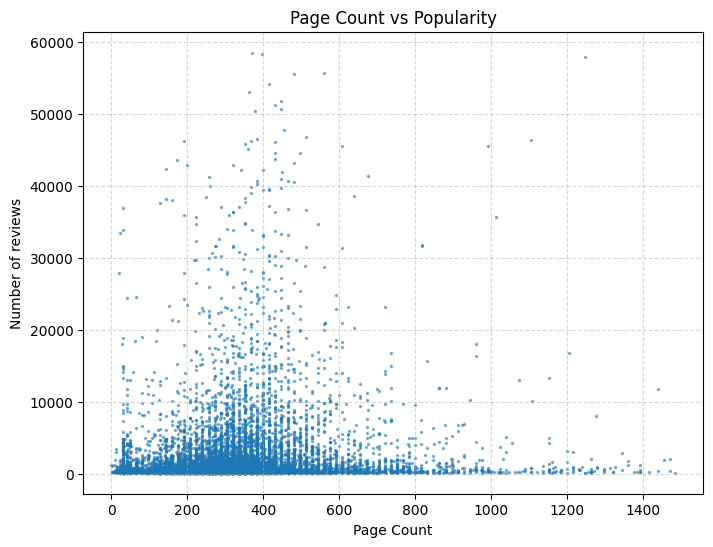

In [9]:
plot_df = books_metadata.dropna(subset=['page_count', 'average_rating','rating_number'])
plot_df = plot_df[plot_df['page_count'] < 1500]
plot_df = plot_df[plot_df['rating_number'] < 60000]
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(plot_df['page_count'], plot_df['rating_number'], alpha=0.5,s=2)
plt.title("Page Count vs Popularity")
plt.xlabel("Page Count")
plt.ylabel("Number of reviews")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


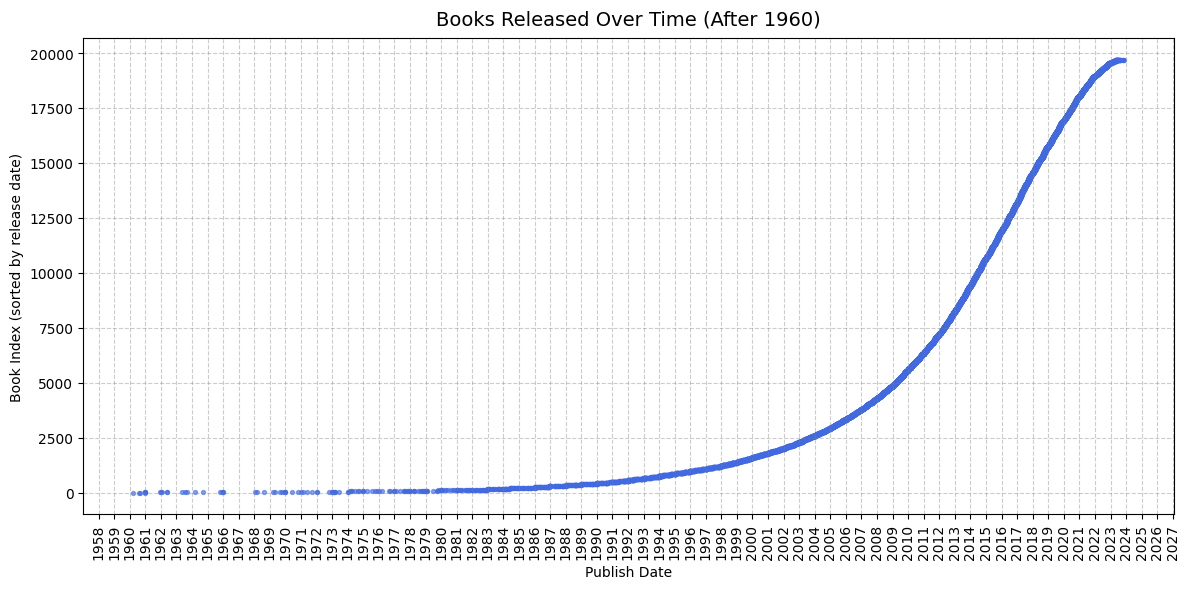

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Filter & sort
plot_df = books_metadata.dropna(subset=['publish_date_fix', 'title'])
plot_df = plot_df.sort_values('publish_date_fix')
plot_df = plot_df[plot_df['publish_date_fix'].dt.year >= 1960]

plt.figure(figsize=(12,6))
plt.scatter(
    plot_df['publish_date_fix'],
    range(len(plot_df)),
    s=8,
    alpha=0.6,
    color='royalblue'
)

plt.title("Books Released Over Time (After 1960)", fontsize=14, pad=10)
plt.xlabel("Publish Date")
plt.ylabel("Book Index (sorted by release date)")

# 🧭 Configure x-axis: one label per year
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())             # tick every year
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))     # show only the year
ax.grid(True, linestyle='--', color='gray', alpha=0.4)       # yearly gridlines only

# Optional: rotate labels for readability
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


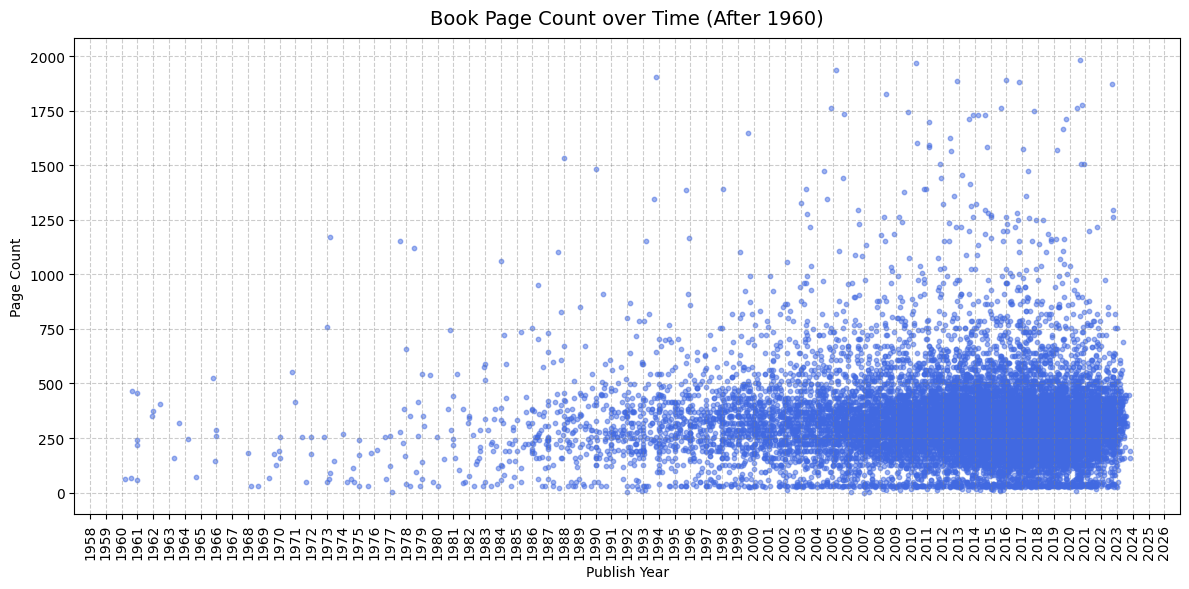

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Filter & clean
plot_df = books_metadata.dropna(subset=['publish_date_fix', 'page_count'])
plot_df = plot_df[plot_df['publish_date_fix'].dt.year >= 1960]
plot_df = plot_df[plot_df['page_count'] < 2000]  # optional: trim extreme outliers

plt.figure(figsize=(12,6))
plt.scatter(
    plot_df['publish_date_fix'],
    plot_df['page_count'],
    s=10,               # smaller point size
    alpha=0.5,
    color='royalblue'
)

plt.title("Book Page Count over Time (After 1960)", fontsize=14, pad=10)
plt.xlabel("Publish Year")
plt.ylabel("Page Count")
plt.grid(True, linestyle='--', color='gray', alpha=0.4)

# 🧭 Configure x-axis: yearly ticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())          # tick every year
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # show only the year
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


In [20]:
books_metadata['category_level_2_sub'].unique()

array(['Politics & Social Sciences', 'Literature & Fiction',
       'Education & Teaching', 'Christian Books & Bibles',
       'Mystery, Thriller & Suspense', 'Business & Money',
       "Children's Books", 'History', 'Science Fiction & Fantasy',
       'Humor & Entertainment', 'Arts & Photography',
       'Religion & Spirituality', 'Science & Math', 'Teen & Young Adult',
       'Health, Fitness & Dieting', 'Biographies & Memoirs',
       'Sports & Outdoors', 'Crafts, Hobbies & Home', 'Romance',
       'Comics & Graphic Novels', 'Cookbooks, Food & Wine', 'Reference',
       'Parenting & Relationships', 'Law', 'Medical Books', 'Self-Help',
       'Computers & Technology', 'Engineering & Transportation',
       'Boxed Sets', 'Foreign Language Books', nan,
       'New, Used & Rental Textbooks', 'LGBTQ+ Books', 'Large Print',
       'Test Preparation', 'Travel', 'Stationery, Journals & Notebooks',
       'ASINs for HQP', 'Deals in Books', 'Popular Suspense',
       'Popover Test', 'Textbook

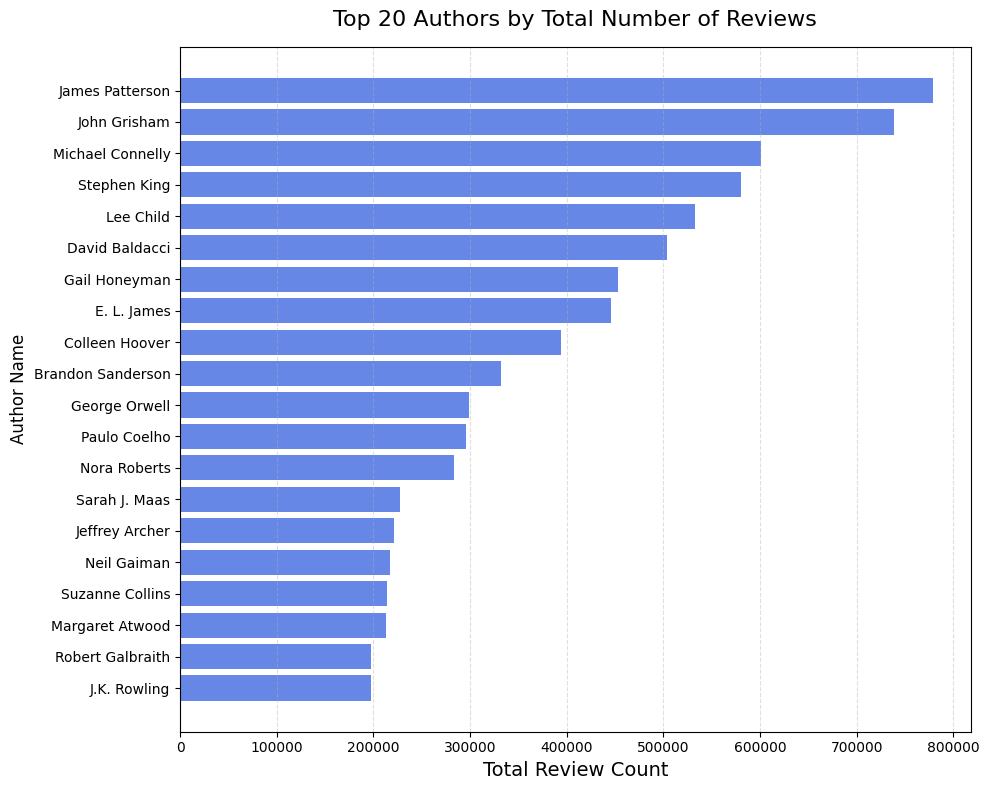

In [22]:
import matplotlib.pyplot as plt

# Compute top 20 authors
author_reviews = (
    books_metadata
    .dropna(subset=['author_name', 'rating_number'])
    .groupby('author_name')['rating_number']
    .sum()
    .sort_values(ascending=False)
)

top20 = author_reviews.head(20)

plt.figure(figsize=(10,8))
plt.barh(top20.index, top20.values, color='royalblue', alpha=0.8)

plt.title("Top 20 Authors by Total Number of Reviews", fontsize=16, pad=15)
plt.xlabel("Total Review Count", fontsize=14)
plt.ylabel("Author Name", fontsize=12)

# Make the highest at the top
plt.gca().invert_yaxis()

# Clean layout
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


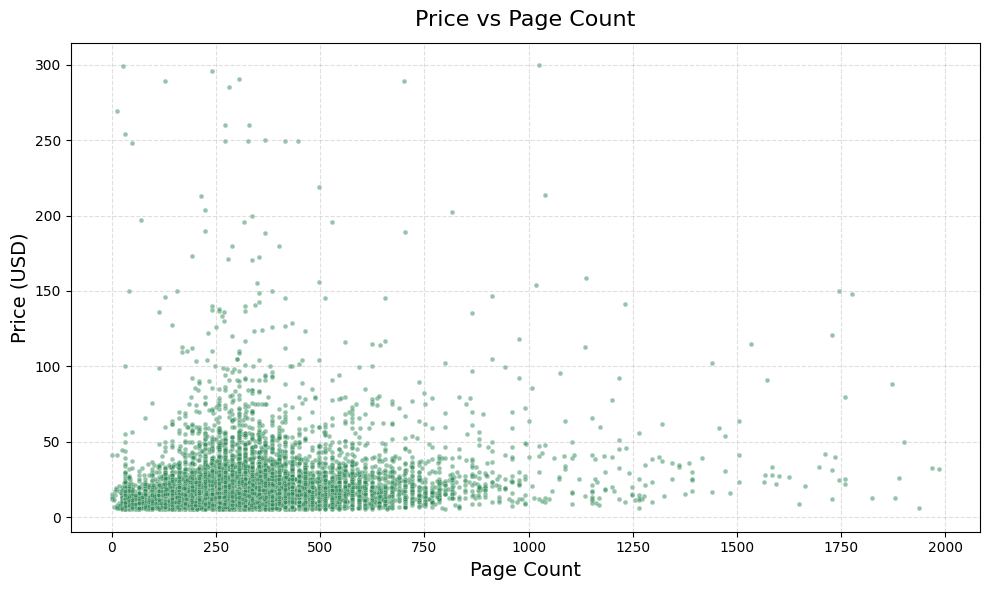

In [26]:
import matplotlib.pyplot as plt
plot_df = books_metadata.dropna(subset=['price', 'page_count'])

# optional: remove extreme outliers
plot_df = plot_df[plot_df['price'] < 300]      
plot_df = plot_df[plot_df['page_count'] < 2000]    # trim very large books


plt.figure(figsize=(10,6))
plt.scatter(
    plot_df['page_count'], 
    plot_df['price'],
    alpha=0.5,
    s=12,
    color='seagreen',
    edgecolors='white',
    linewidths=0.3
)

plt.title("Price vs Page Count", fontsize=16, pad=12)
plt.xlabel("Page Count", fontsize=14)
plt.ylabel("Price (USD)", fontsize=14)

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [37]:
df2

,Unnamed: 0,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,date,year
0,0,5.0,Good choice,Just what I was looking for. Thank you.,[],1477493395,1477493395,AGXFEGMNVCSTSYYA5UWXDV7AFSXA,1529789386700,1,True,2018-06-23 21:29:46.700,2018
1,1,3.0,Perfect size,Very small lines to color had to get 4.0 marke...,[],1780679548,1780679548,AGPR2UDFIJJCBA3EKFEEAJBWKROQ,1591370837527,0,True,2020-06-05 15:27:17.527,2020
2,2,1.0,Much of this book was unbelievable and I almos...,Hard to get through was very disappointed with...,[],1785588451,1785588451,AEUH4EH6XHROLT7UZPUYU2YKTYMA,1618447014407,1,True,2021-04-15 00:36:54.407,2021
3,3,5.0,Great Buy!,"This series was requested by my grandson, who ...",[],1606412388,1606412388,AH6PLOGWYIVIWLJTY756BHNFD4YA,1340195874000,0,True,2012-06-20 12:37:54.000,2012
4,4,5.0,You can go home again!,"I love John Grogan, he has always been one of ...",[],0061713244,0061713244,AFSKPY37N3C43SOI5IEXEK5JSIYA,1224796701000,1,False,2008-10-23 21:18:21.000,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...
727871,727871,5.0,Wonderful book,"book was in pretty good condition, although it...",[],0385029551,0385029551,AEN5KGFRBLAL6DDS3NAIFIO6AGLQ,1566948982155,0,True,2019-08-27 23:36:22.155,2019
727872,727872,5.0,the confessions of saint augustine,The book is more that I expected. Very easy to...,[],0385029551,0385029551,AETVXFZKRR4SMXPEH3ZLWY7XK7MQ,1348369689000,0,True,2012-09-23 03:08:09.000,2012
727873,727873,3.0,Three Stars,Sadly there are worn pages T.T,[],0385029551,0385029551,AG5EZ6YJWG7XRB2FMPU5CTYKORCA,1404348284000,0,True,2014-07-03 00:44:44.000,2014
727874,727874,5.0,Dangerous Indeed,This collection of essays makes a serious argu...,[],1250179459,1250179459,AFEBIBOLNGBERBVTBTLWRANULVQA,1510772157872,1,True,2017-11-15 18:55:57.872,2017


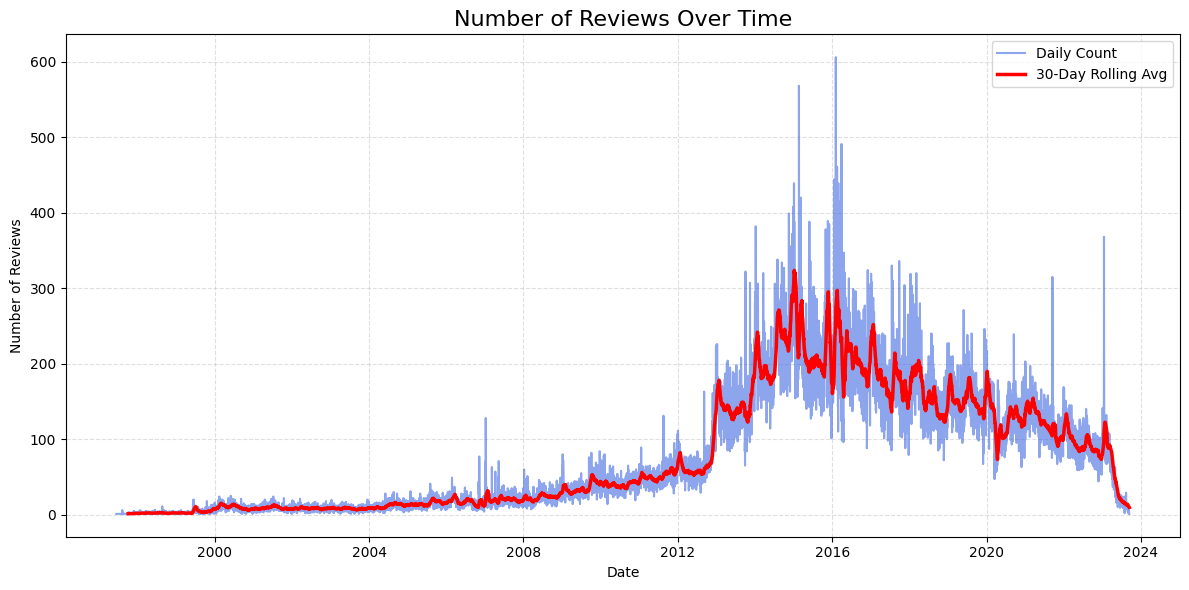

In [75]:
df2['date'] = pd.to_datetime(df2['date'], errors='coerce')
df2 = df2.dropna(subset=['date'])
daily_reviews = df2.groupby(df2['date'].dt.date).size()
import matplotlib.pyplot as plt

# 30-day rolling mean for smoothing
smooth = daily_reviews.rolling(30).mean()

plt.figure(figsize=(12,6))

# Original daily line
plt.plot(daily_reviews.index, daily_reviews.values, 
         color='royalblue', alpha=0.6, label='Daily Count')

# Smooth trend line
plt.plot(smooth.index, smooth.values, 
         color='red', linewidth=2.5, label='30-Day Rolling Avg')

plt.title("Number of Reviews Over Time", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Number of Reviews")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()



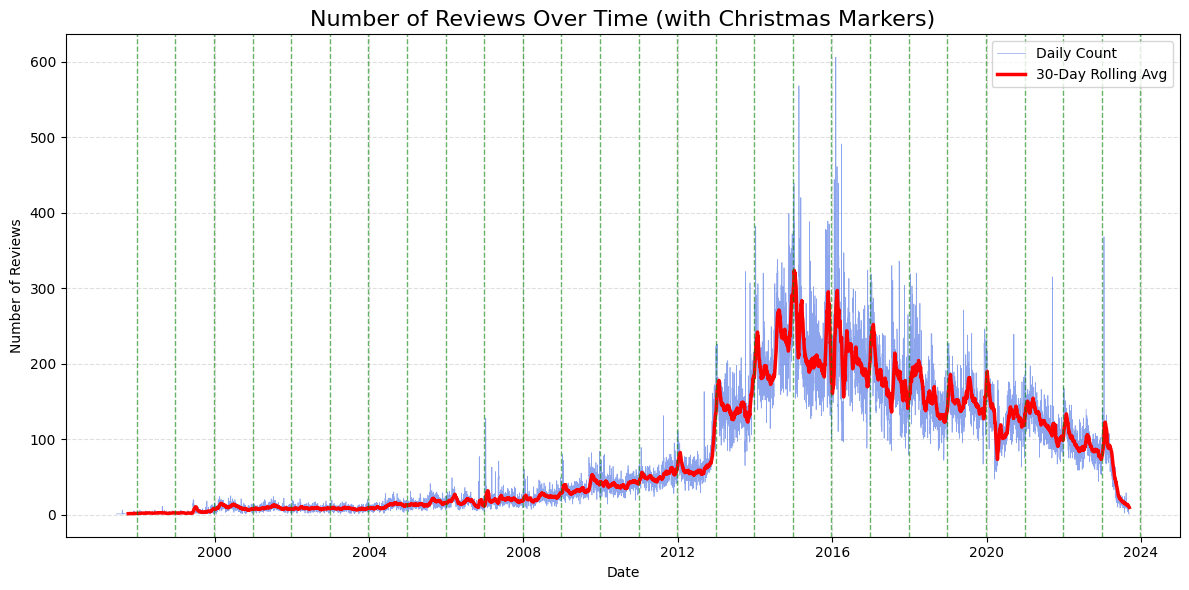

In [79]:
df2['date'] = pd.to_datetime(df2['date'], errors='coerce')
df2 = df2.dropna(subset=['date'])

# group daily
daily_reviews = df2.groupby(df2['date'].dt.date).size()

# smoothing
smooth = daily_reviews.rolling(30).mean()

import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12,6))

# original line
plt.plot(daily_reviews.index, daily_reviews.values, 
         color='royalblue',linewidth=0.5, alpha=0.6, label='Daily Count')

# smooth line
plt.plot(smooth.index, smooth.values, 
         color='red', linewidth=2.5, label='30-Day Rolling Avg')

# === 🎄 add Christmas lines ===
years = sorted(df2['date'].dt.year.unique())
christmas_dates = [pd.Timestamp(f"{y}-12-25") for y in years]

for x in christmas_dates:
    plt.axvline(x=x, color='green', linestyle='--', linewidth=1, alpha=0.6)

# labels
plt.title("Number of Reviews Over Time (with Christmas Markers)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Number of Reviews")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


In [42]:
df2

,Unnamed: 0,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,date,year,review_date
0,0,5.0,Good choice,Just what I was looking for. Thank you.,[],1477493395,1477493395,AGXFEGMNVCSTSYYA5UWXDV7AFSXA,1529789386700,1,True,2018-06-23 21:29:46.700,2018,2018-06-23 21:29:46.700
1,1,3.0,Perfect size,Very small lines to color had to get 4.0 marke...,[],1780679548,1780679548,AGPR2UDFIJJCBA3EKFEEAJBWKROQ,1591370837527,0,True,2020-06-05 15:27:17.527,2020,2020-06-05 15:27:17.527
2,2,1.0,Much of this book was unbelievable and I almos...,Hard to get through was very disappointed with...,[],1785588451,1785588451,AEUH4EH6XHROLT7UZPUYU2YKTYMA,1618447014407,1,True,2021-04-15 00:36:54.407,2021,2021-04-15 00:36:54.407
3,3,5.0,Great Buy!,"This series was requested by my grandson, who ...",[],1606412388,1606412388,AH6PLOGWYIVIWLJTY756BHNFD4YA,1340195874000,0,True,2012-06-20 12:37:54.000,2012,2012-06-20 12:37:54.000
4,4,5.0,You can go home again!,"I love John Grogan, he has always been one of ...",[],0061713244,0061713244,AFSKPY37N3C43SOI5IEXEK5JSIYA,1224796701000,1,False,2008-10-23 21:18:21.000,2008,2008-10-23 21:18:21.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727871,727871,5.0,Wonderful book,"book was in pretty good condition, although it...",[],0385029551,0385029551,AEN5KGFRBLAL6DDS3NAIFIO6AGLQ,1566948982155,0,True,2019-08-27 23:36:22.155,2019,2019-08-27 23:36:22.155
727872,727872,5.0,the confessions of saint augustine,The book is more that I expected. Very easy to...,[],0385029551,0385029551,AETVXFZKRR4SMXPEH3ZLWY7XK7MQ,1348369689000,0,True,2012-09-23 03:08:09.000,2012,2012-09-23 03:08:09.000
727873,727873,3.0,Three Stars,Sadly there are worn pages T.T,[],0385029551,0385029551,AG5EZ6YJWG7XRB2FMPU5CTYKORCA,1404348284000,0,True,2014-07-03 00:44:44.000,2014,2014-07-03 00:44:44.000
727874,727874,5.0,Dangerous Indeed,This collection of essays makes a serious argu...,[],1250179459,1250179459,AFEBIBOLNGBERBVTBTLWRANULVQA,1510772157872,1,True,2017-11-15 18:55:57.872,2017,2017-11-15 18:55:57.872


<Axes: ylabel='Frequency'>

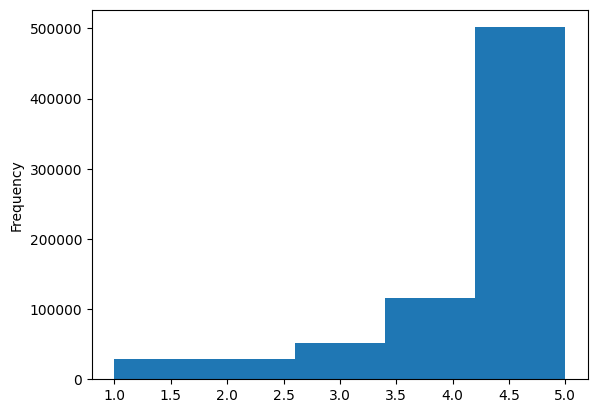

In [43]:
df2['rating'].plot(kind='hist', bins=5)


<Axes: xlabel='date'>

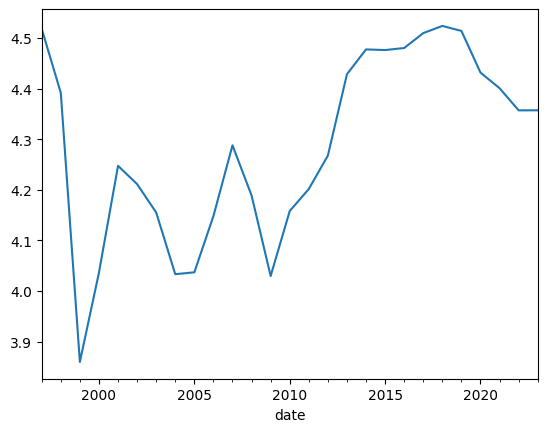

In [44]:
df2.groupby(df2['date'].dt.to_period("Y"))['rating'].mean().plot()


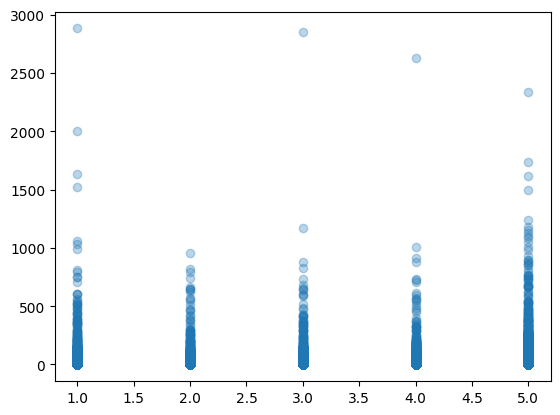

In [46]:
# Are 1 star reviews more likely to get upvotes?
plt.scatter(df2['rating'], df2['helpful_vote'], alpha=0.3)


<Axes: xlabel='verified_purchase', ylabel='rating'>

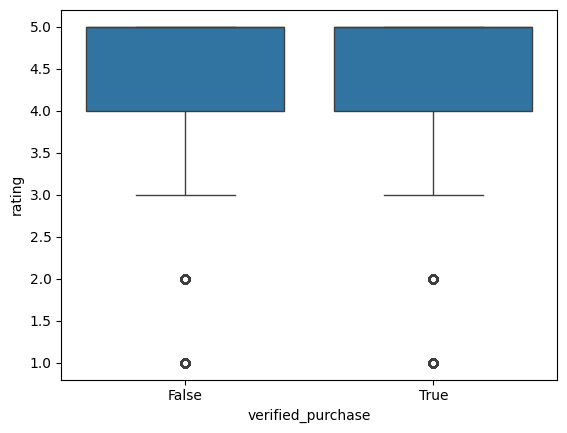

In [50]:
import seaborn as sns
sns.boxplot(x='verified_purchase', y='rating', data=df2)


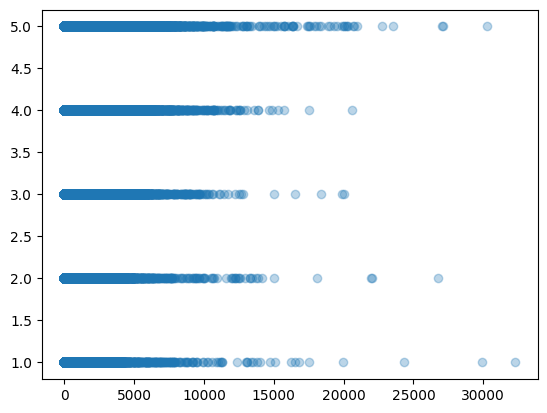

In [53]:
#
df2['text_len'] = df2['text'].str.len()
plt.scatter(df2['text_len'], df2['rating'], alpha=0.3)


<Axes: xlabel='review_date', ylabel='year'>

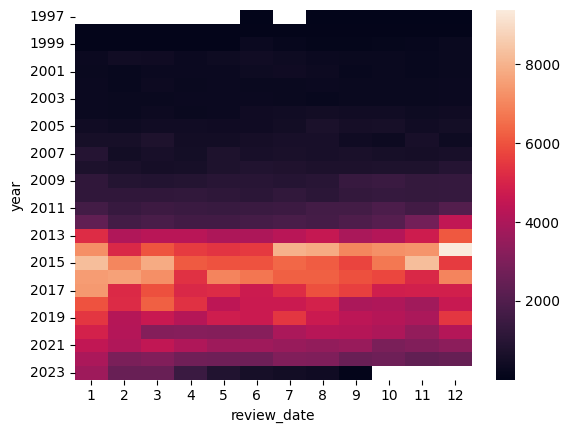

In [54]:
df2['year_month'] = df2['review_date'].dt.to_period('M')
heat = df2.groupby(['year', df2['review_date'].dt.month]).size().unstack()
sns.heatmap(heat)


<Axes: xlabel='weekday'>

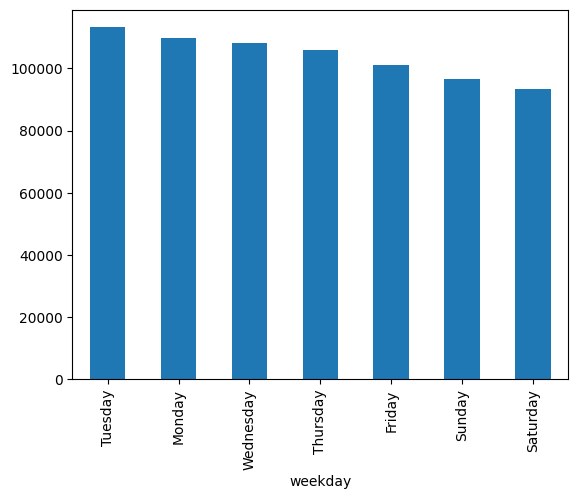

In [55]:
df2['weekday'] = df2['review_date'].dt.day_name()
df2['weekday'].value_counts().plot(kind='bar')


<Axes: xlabel='user_id'>

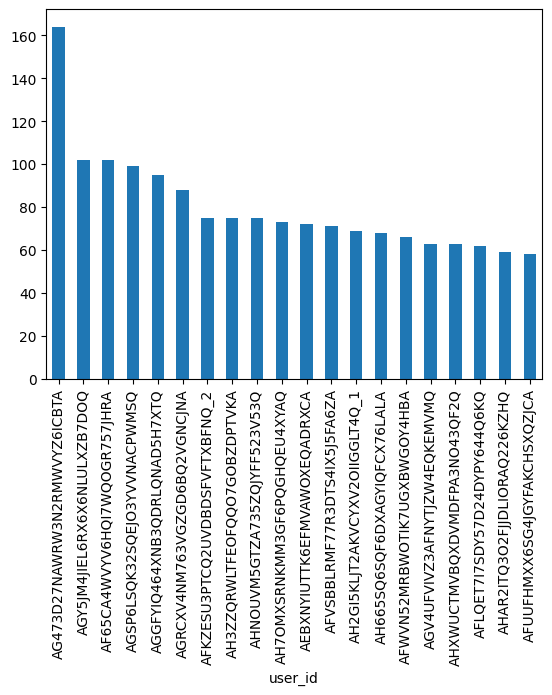

In [56]:
df2['user_id'].value_counts().head(20).plot(kind='bar')


<Axes: ylabel='title'>

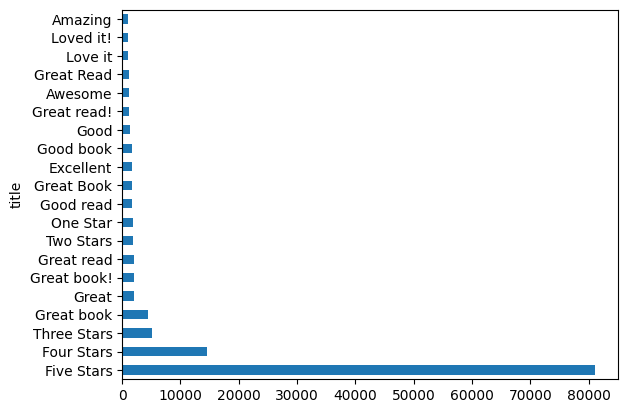

In [57]:
df2['title'].value_counts().head(20).plot(kind='barh')


In [59]:
df1.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'title', 'subtitle', 'author_name',
       'author_about', 'publisher', 'publisher_date', 'format', 'page_count',
       'language', 'isbn_10', 'isbn_13', 'main_category',
       'category_level_1_main', 'category_level_2_sub',
       'category_level_3_detail', 'average_rating', 'rating_number', 'price',
       'price_numeric', 'description', 'features_text', 'dimensions',
       'item_weight', 'images', 'videos', 'store', 'parent_asin',
       'bought_together', 'clean_date_str', 'publish_date_fix'],
      dtype='object')

In [60]:
merged = pd.merge(books_metadata, df2, on='parent_asin', how='inner')


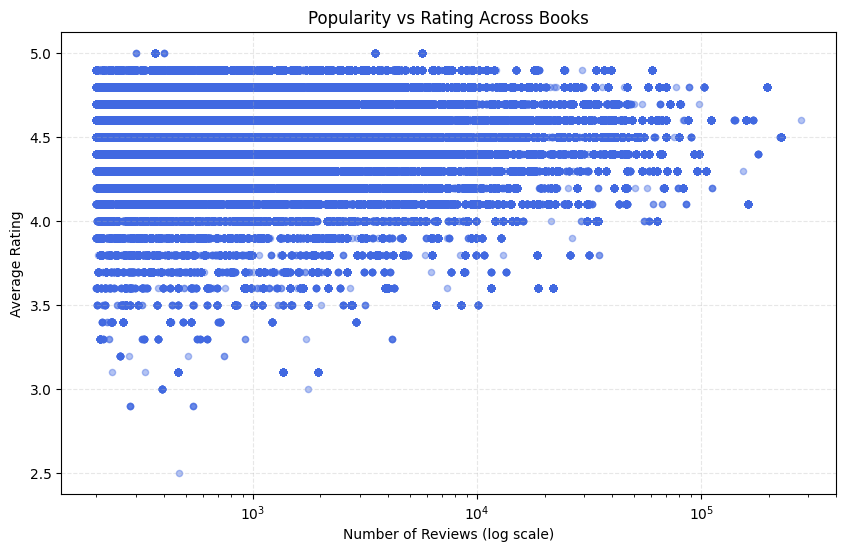

In [61]:
merged = pd.merge(books_metadata, df2, on='parent_asin', how='left')

plt.figure(figsize=(10,6))
plt.scatter(
    merged['rating_number'],
    merged['average_rating'],
    alpha=0.4,
    s=20,
    color='royalblue'
)

plt.xscale('log')
plt.xlabel("Number of Reviews (log scale)")
plt.ylabel("Average Rating")
plt.title("Popularity vs Rating Across Books")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


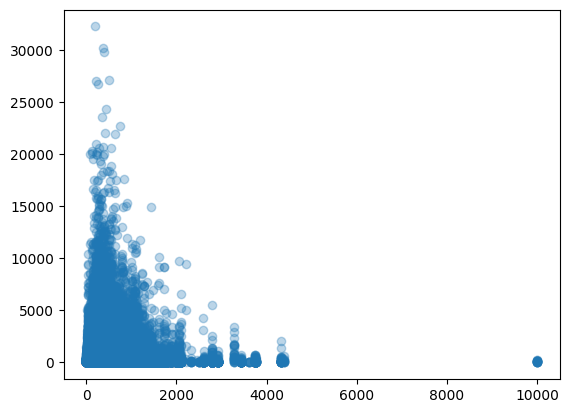

In [63]:
#Page count vs Review length
df2['text_len'] = df2['text'].str.len()
merged = pd.merge(books_metadata, df2, on='parent_asin')
plt.scatter(merged['page_count'], merged['text_len'], alpha=0.3)


<Axes: title={'center': 'average_rating'}, xlabel='main_category'>

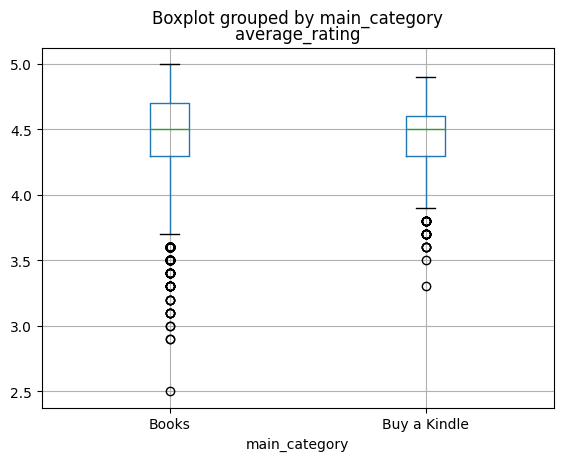

In [64]:
books_metadata.boxplot(column="average_rating", by="main_category")


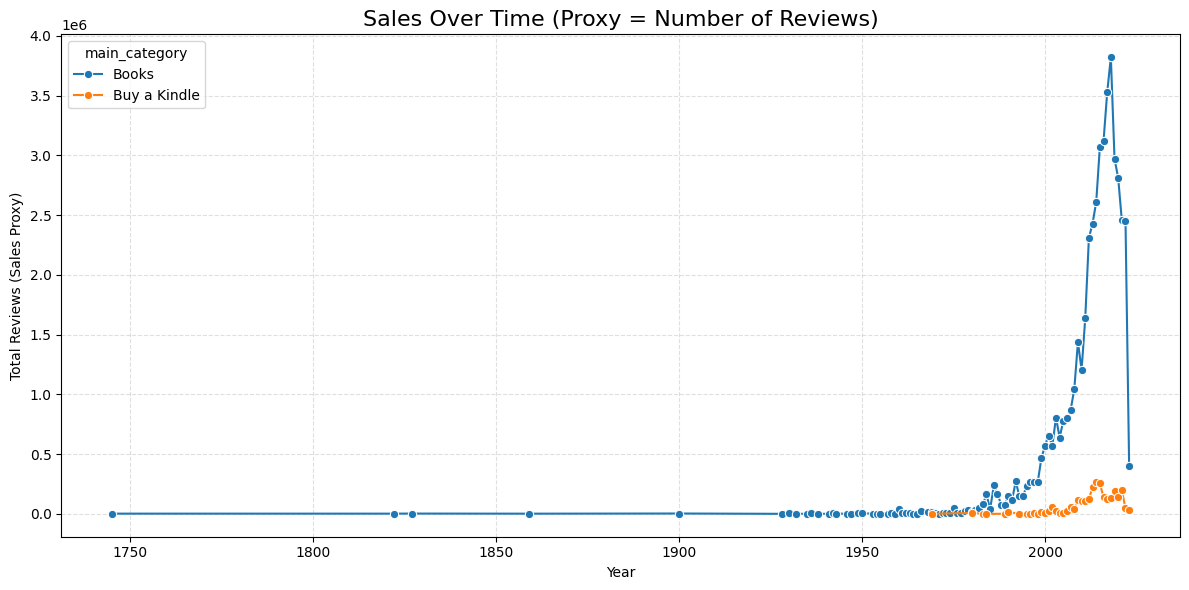

In [74]:
plot_df = books_metadata.dropna(subset=['main_category', 'publish_date_fix', 'rating_number'])

plot_df = plot_df[
    plot_df['main_category'].isin(['Books', 'Buy a Kindle'])
]

# Ensure datetime type
plot_df['publish_date_fix'] = pd.to_datetime(
    plot_df['publish_date_fix'], errors='coerce'
)

# Extract year
plot_df['year'] = plot_df['publish_date_fix'].dt.year

category_year = (
    plot_df
    .groupby(['main_category', 'year'])['rating_number']
    .sum()
    .reset_index()
)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.lineplot(
    data=category_year,
    x='year',
    y='rating_number',
    hue='main_category',
    marker='o'
)

plt.title("Sales Over Time (Proxy = Number of Reviews)", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Total Reviews (Sales Proxy)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



In [68]:
df1

,Unnamed: 0.1,Unnamed: 0,title,subtitle,author_name,author_about,publisher,publisher_date,format,page_count,language,isbn_10,isbn_13,main_category,category_level_1_main,category_level_2_sub,category_level_3_detail,average_rating,rating_number,price,price_numeric,description,features_text,dimensions,item_weight,images,videos,store,parent_asin,bought_together,clean_date_str,publish_date_fix
0,0,0,Government Bullies: How Everyday Americans are...,"Paperback – August 6, 2013",Rand Paul,"Discover more of the author’s books, see simil...",Center Street,"41260th edition (August 6, 2013",Paperback,320.0,English,1455522775,978-1455522774,Books,Books,Politics & Social Sciences,Politics & Government,4.6,274,12.99,12.99,"['Review', 'Praise for The Tea Party Goes to W...",Government regulations are out of control. The...,5.25 x 0.81 x 8 inches,9.2 ounces,[{'large': 'https://m.media-amazon.com/images/...,[],"Rand Paul (Author), Ron Paul (Foreword)",1455522775,NaN,"August 6, 2013",2013-08-06
1,1,1,Gordon Pope Thrillers: Books 1-3,"Paperback – December 17, 2020",B. B. Griffith,"B. B. Griffith was born and raised in Denver, ...",Griffith Publishing LLC,"December 17, 2020",Paperback,694.0,English,1735305855,978-1735305851,Books,Books,Literature & Fiction,Genre Fiction,4.6,626,24.69,24.69,"['Review', 'Selected Reviews from the Gordon P...",Gordon Pope has a special talent. | He's the o...,6 x 1.74 x 9 inches,2.21 pounds,[{'large': 'https://m.media-amazon.com/images/...,[],B. B. Griffith (Author),1735305855,NaN,"December 17, 2020",2020-12-17
2,2,2,Chart Sense: Common Sense Charts to Teach 3-8 ...,"Paperback – Illustrated, February 2, 2014",Rozlyn Linder,Follow Roz on Twitter (@rozlinder) and connect...,"Literacy Initiative, The","Illustrated edition (February 2, 2014",Paperback,182.0,English,0988950510,978-0988950511,Books,Books,Education & Teaching,Schools & Teaching,4.7,272,22.88,22.88,"['Review', ""This is the first book I have ever...",Chart Sense is the ultimate resource for eleme...,7.5 x 0.41 x 9.25 inches,12 ounces,[],[],Rozlyn Linder (Author),0988950510,NaN,"February 2, 2014",2014-02-02
3,3,3,Where the Sky Begins: A Novel,"Paperback – August 2, 2022",Rhys Bowen,Rhys Bowen is the New York Times bestselling a...,Lake Union Publishing,"August 2, 2022",Paperback,399.0,English,1542028841,978-1542028844,Books,Books,Literature & Fiction,Genre Fiction,4.5,27244,6.15,6.15,"['Review', '“Bowen is a master at winning read...",A woman’s future is determined by fate and cho...,5.5 x 1 x 8.25 inches,14.1 ounces,[],[],Rhys Bowen (Author),1542028841,NaN,"August 2, 2022",2022-08-02
4,4,4,The Mystery of Garabandal: Fantasy or Fraud? G...,NaN,LR Walker,"Discover more of the author’s books, see simil...",Newtonia Publishing LLC,"First Paperback Edition (July 31, 2015",Paperback,299.0,English,0692297677,978-0692297674,Books,Books,Christian Books & Bibles,Theology,4.5,287,12.99,12.99,"['About the Author', ""LR Walker studied journa...",This 2021 update includes new interviews with ...,6 x 0.68 x 9 inches,14.3 ounces,[{'large': 'https://m.media-amazon.com/images/...,[],"LR Walker (Author), Frank Lafleur (Introduction)",0692297677,NaN,"July 31, 2015",2015-07-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19995,19995,The Prayer of the Lord,"Hardcover – May 26, 2009",R. C. Sproul,Dr. R.C. Sproul (1939–2017) was founder of Lig...,Reformation Trust Publishing,"May 26, 2009",Hardcover,130.0,English,1567691188,978-1567691184,Books,Books,Christian Books & Bibles,Worship & Devotion,4.7,512,18.67,18.67,"['Review', ""R.C. Sproul has an amazing gift fo...",What is the Lord’s Prayer? In | The Prayer of ...,5.31 x 0.63 x 7.75 inches,9.6 ounces,[{'large': 'https://m.media-amazon.com/images/...,[],R.C. Sproul (Author),1567691188,NaN,"May 26, 2009",2009-05-26
19996,19996,19996,A Christmas Carol,"Hardcover – September 3, 2012",Robert Ingpen,"Robert Ingpen was born in 1936 in Geelong, Au

In [11]:
df1[df1['price']>300].sort_values(by='price',ascending=False)

,Unnamed: 0.1,Unnamed: 0,title,subtitle,author_name,author_about,publisher,publisher_date,format,page_count,language,isbn_10,isbn_13,main_category,category_level_1_main,category_level_2_sub,category_level_3_detail,average_rating,rating_number,price,price_numeric,description,features_text,dimensions,item_weight,images,videos,store,parent_asin,bought_together,clean_date_str,publish_date_fix
4212,4212,4212,Love & Light: 44 Divine Guidance Cards and Gui...,"Cards – June 12, 2018",Doreen Virtue,PLEASE NOTE: DOREEN IS NOT SELLING NEW AGE PRO...,"Hay House, Inc.","Crds edition (June 12, 2018",NaN,NaN,English,1401950450,978-1401950453,Books,Books,Christian Books & Bibles,Christian Living,4.7,654,11568.31,11568.31,"['About the Author', 'Doreen Virtue', 'is a Ch...",Connect with God’s Infinite Love & Light | Eve...,4 x 1.32 x 5.5 inches,11.5 ounces,[{'large': 'https://m.media-amazon.com/images/...,[],Doreen Virtue (Author),1401950450,NaN,"June 12, 2018",2018-06-12
9714,9714,9714,Last Unicorn: The Deluxe Edition,"Hardcover – May 29, 2012",Peter S. Beagle,Peter S. Beagle was born in 1939 and raised in...,IDW Publishing,"Deluxe edition (May 29, 2012",Hardcover,200.0,English,1613771355,978-1613771358,Books,Books,Comics & Graphic Novels,Graphic Novels,4.4,755,1599.97,1599.97,"['About the Author', 'Peter S. Beagle', 'is a ...",Whimsical. Lyrical. Poignant. Adapted for the ...,8.7 x 0.7 x 13.1 inches,2.79 pounds,[{'large': 'https://m.media-amazon.com/images/...,[],"Peter S. Beagle (Author), Peter B. Gillis (Au...",1613771355,NaN,"May 29, 2012",2012-05-29
2613,2613,2613,Bachour The Baker,"Hardcover – November 1, 2017",Battman,"Alan Batt, better known in the culinary world ...",The Chefs Connection,"First Edition (November 1, 2017",Hardcover,200.0,English,0933477538,978-0933477537,Books,Books,"Cookbooks, Food & Wine",Baking,4.6,569,998.99,998.99,"['Review', 'Antonio has a unique ability to cr...",'BEST PASTRY CHEF IN THE WORLD' Pastry Competi...,NaN,2.5 pounds,[{'large': 'https://m.media-amazon.com/images/...,[],"Antonio Bachour (Author), Battman (Editor, Il...",0933477538,NaN,"November 1, 2017",2017-11-01
16790,16790,16790,"Words Their Way: Word Study for Phonics, Vocab...",NaN,Donald R. Bear,Donald is director of the E. L. Cord Foundatio...,Pearson,"7th edition (May 30, 2019",Paperback,576.0,English,0135174627,978-0135174623,Books,Books,Education & Teaching,Schools & Teaching,4.6,212,990.00,990.00,"['Review', '“[', 'Words Their Way', '] provide...","NOTE: | Before purchasing, check with your ins...",9 x 6 x 1.25 inches,2.3 pounds,[{'large': 'https://m.media-amazon.com/images/...,[],"Donald Bear (Author), Marcia Invernizzi (Auth...",0135174627,NaN,"May 30, 2019",2019-05-30
3882,3882,3882,Llama Llama Red Pajama (Puffin Storytime),"Paperback – November 8, 2012",Anna Dewdney,Anna Dewdney was an award-winning children's-b...,Puffin,"November 8, 2012",Paperback,40.0,English,0142423424,978-0142423424,Books,Books,Children's Books,Growing Up & Facts of Life,4.8,11832,895.00,895.00,"['About the Author', 'Anna Dewdney lives in so...",Puffin Storytime book-and-CD library adds anot...,5.25 x 1.25 x 5.75 inches,12.6 ounces,[{'large': 'https://m.media-amazon.com/images/...,[],"Anna Dewdney (Author, Illustrator)",0142423424,NaN,"November 8, 2012",2012-11-08
3706,3706,3706,Sally Mann: Immediate Family,"Hardcover – Illustrated, June 30, 2014",Sally Mann,Sally Mann (born 1951) is an American photogra...,Aperture,"Illustrated edition (June 30, 2014",Hardcover,88.0,English,1597112542,978-1597112543,Books,Books,Arts & Photography,Photography & Video,4.5,225,620.41,620.41,"['Review', 'the book that catapulted her caree...","First published in 1992, | Immediate Family | ...",9.8 x 0.7 x 11.4 inches,1.94 pounds,[{'large': 'https://m.media-amazon.com/images/...,[],"Sally Mann (Photographer, Contributor), Reyno...",1597112542,NaN,"June 30, 2014",2014-06-30
7398,7398,7398,"Barron's NYSTCE, 4th Edition: EAS / ALST / CST...",4th Edition,Robert D. Postman,"Robert Postman is

Goal: Who do we want to present this to?
- Authors and Publishers: Evaluate books compare competitors, rack review trend overtime, and identify the best-performing genres for future publishing focus

Authors -> When thhey want to write the book
- What categories are the best sellers? People want to make make money out of books.
- Which publisher to choose?
- How should we price the books?
- Word cloud for reviews text -> what they like the most in that particlar genre

Authors -> after writing book (maintaining image, analytics of current performing books)
- Check user id which has bought the most book from the author. -> ranking of number of books bought -> the story is we can give them discount and send them a thankyou letter or sth.
- Time series, of number of reviews over time.
- How good their books (the authors) are compared to other authors?
- Word cloud for reviews text -> what they like they don't like about the published books.

In [12]:
df2

,Unnamed: 0,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,date,year
0,0,5.0,Good choice,Just what I was looking for. Thank you.,[],1477493395,1477493395,AGXFEGMNVCSTSYYA5UWXDV7AFSXA,1529789386700,1,True,2018-06-23 21:29:46.700,2018
1,1,3.0,Perfect size,Very small lines to color had to get 4.0 marke...,[],1780679548,1780679548,AGPR2UDFIJJCBA3EKFEEAJBWKROQ,1591370837527,0,True,2020-06-05 15:27:17.527,2020
2,2,1.0,Much of this book was unbelievable and I almos...,Hard to get through was very disappointed with...,[],1785588451,1785588451,AEUH4EH6XHROLT7UZPUYU2YKTYMA,1618447014407,1,True,2021-04-15 00:36:54.407,2021
3,3,5.0,Great Buy!,"This series was requested by my grandson, who ...",[],1606412388,1606412388,AH6PLOGWYIVIWLJTY756BHNFD4YA,1340195874000,0,True,2012-06-20 12:37:54.000,2012
4,4,5.0,You can go home again!,"I love John Grogan, he has always been one of ...",[],0061713244,0061713244,AFSKPY37N3C43SOI5IEXEK5JSIYA,1224796701000,1,False,2008-10-23 21:18:21.000,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...
727871,727871,5.0,Wonderful book,"book was in pretty good condition, although it...",[],0385029551,0385029551,AEN5KGFRBLAL6DDS3NAIFIO6AGLQ,1566948982155,0,True,2019-08-27 23:36:22.155,2019
727872,727872,5.0,the confessions of saint augustine,The book is more that I expected. Very easy to...,[],0385029551,0385029551,AETVXFZKRR4SMXPEH3ZLWY7XK7MQ,1348369689000,0,True,2012-09-23 03:08:09.000,2012
727873,727873,3.0,Three Stars,Sadly there are worn pages T.T,[],0385029551,0385029551,AG5EZ6YJWG7XRB2FMPU5CTYKORCA,1404348284000,0,True,2014-07-03 00:44:44.000,2014
727874,727874,5.0,Dangerous Indeed,This collection of essays makes a serious argu...,[],1250179459,1250179459,AFEBIBOLNGBERBVTBTLWRANULVQA,1510772157872,1,True,2017-11-15 18:55:57.872,2017
